## Device

In [163]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# torch.set_default_device("cpu")
# torch.set_default_dtype(torch.float16)
# torch.set_default_tensor_type("torch.cuda.FloatTensor")

## Model architecture

### CNN encoder

In [164]:
import torch
from torch import nn


class Encoder(nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int):
        """
        Encodes the 28*28 image vid a CNN network into hidden_channels channels of 7*7 representation.
        :param in_channels: how many color channels the image has.
        :param hidden_channels: how many channels the image should be encoded into.
        """
        super().__init__()

        self.lrelu = nn.ReLU()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            self.lrelu,
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            self.lrelu,
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            self.lrelu,
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            self.lrelu,
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block_2(x)
        return x


### Linear decoder

In [165]:
import torch
from torch import nn


class Decoder(nn.Module):
    def __init__(self, output_classes: int, hidden_channels: int):
        """
        Decodes (classifies) the encoded image into one of output_classes classes.
        :param output_classes: how many classes the image could have.
        :param hidden_channels: how many hidden channels the image should be decoded from.
        """
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_channels * 7 * 7,
                      out_features=output_classes),
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

### Combined model

In [166]:
import torch
from torch import nn


class Model(nn.Module):
    def __init__(self, in_channels: int, output_classes: int, hidden_channels: int):
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels, hidden_channels=hidden_channels).to(device=device)
        self.decoder = Decoder(hidden_channels=hidden_channels, output_classes=output_classes).to(device=device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = Model(in_channels=1,
              output_classes=10,
              hidden_channels=10).to(device=device)

## Training data

In [167]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root='mnist_data',
                            train=True,
                            download=True,
                            transform=ToTensor(),
                            target_transform=None)

test_data = datasets.MNIST(root='mnist_data',
                           train=False,
                           download=True,
                           transform=ToTensor(),
                           target_transform=None)

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)


## Training Loop

E 1/10 | Batch 1/1,875 | Loss: 2.297471761703491
E 1/10 | Batch 2/1,875 | Loss: 2.416947841644287
E 1/10 | Batch 3/1,875 | Loss: 2.305690288543701
E 1/10 | Batch 4/1,875 | Loss: 2.3305346965789795
E 1/10 | Batch 5/1,875 | Loss: 2.2918217182159424
E 1/10 | Batch 6/1,875 | Loss: 2.3256185054779053
E 1/10 | Batch 7/1,875 | Loss: 2.305002212524414
E 1/10 | Batch 8/1,875 | Loss: 2.306936264038086
E 1/10 | Batch 9/1,875 | Loss: 2.3127245903015137
E 1/10 | Batch 10/1,875 | Loss: 2.3006863594055176
E 1/10 | Batch 11/1,875 | Loss: 2.3020360469818115
E 1/10 | Batch 12/1,875 | Loss: 2.295071601867676
E 1/10 | Batch 13/1,875 | Loss: 2.2762668132781982
E 1/10 | Batch 14/1,875 | Loss: 2.286203622817993
E 1/10 | Batch 15/1,875 | Loss: 2.2654755115509033
E 1/10 | Batch 16/1,875 | Loss: 2.3034462928771973
E 1/10 | Batch 17/1,875 | Loss: 2.2242681980133057
E 1/10 | Batch 18/1,875 | Loss: 2.165238857269287
E 1/10 | Batch 19/1,875 | Loss: 2.215682029724121
E 1/10 | Batch 20/1,875 | Loss: 2.138330698013305

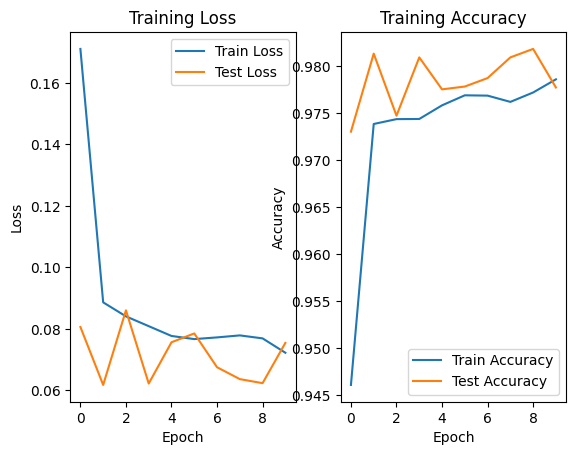

In [168]:
import torch
from torch import nn
from timeit import default_timer as timer
import numpy as np

EPOCHS = 10
LEARNING_RATE = 0.01
UPDATE_PARAMETERS_EVERY_NUM_BATCHES = 1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
current_batch = 0

for epoch in range(EPOCHS):
    model.train()

    train_loss, test_loss = 0, 0
    train_accuracy, test_accuracy = 0, 0

    for train_batch_index, (X_batch, Y_batch) in enumerate(train_dataloader):
        x_batch, y_batch = X_batch.to(device=device), Y_batch.to(device=device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)
        train_loss += loss.item() * len(y_batch)
        current_batch += 1
        loss.backward()

        if current_batch % UPDATE_PARAMETERS_EVERY_NUM_BATCHES == 0:
            optimizer.step()
            optimizer.zero_grad()
            current_batch = 0

        print(
            f"E {epoch + 1:,}/{EPOCHS:,} | Batch {train_batch_index + 1:,}/{len(train_dataloader):,} | Loss: {loss.item():,}")

        predictions = torch.argmax(outputs, dim=1)
        for index, prediction in enumerate(predictions):
            if prediction == y_batch[index]:
                train_accuracy += 1

    train_loss /= len(train_data)
    train_accuracy /= len(train_data)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    with torch.inference_mode():
        model.eval()
        for test_batch_index, (X_batch, Y_batch) in enumerate(test_dataloader):
            x_batch, y_batch = X_batch.to(device=device), Y_batch.to(device=device)
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            test_loss += loss.item() * len(y_batch)

            print(
                f"E {epoch + 1:,}/{EPOCHS:,} | Test batch {test_batch_index + 1:,}/{len(test_dataloader):,} | Loss: {loss.item():,}")

            predictions = torch.argmax(outputs, dim=1)
            for index, prediction in enumerate(predictions):
                if prediction == y_batch[index]:
                    test_accuracy += 1

    test_loss /= len(test_data)
    test_accuracy /= len(test_data)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(train_loss_history, label='Train Loss')
ax1.plot(test_loss_history, label='Test Loss')
ax1.title.set_text('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracy_history, label='Train Accuracy')
ax2.plot(test_accuracy_history, label='Test Accuracy')
ax2.title.set_text('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()